In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 104)
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

import statsmodels.api as sm
from statsmodels.formula.api import ols

## Loading in data

In [3]:
df = pd.read_excel('/Users/mckayladavid/Documents/GitHub/Group019_WI24/data/tech_layoffs.xlsx')
df

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,3286,Pitch,Berlin,Germany,Europe,80,2024-08-01,67.0,119,39,Other,Series B,$138,2024,52.52437,13.41053
1414,3287,BenchSci,Toronto,Canada,North America,70,2024-08-01,17.0,412,342,Healthcare,Series D,$164,2024,43.70643,-79.39864
1415,3288,NanoString Technology,Seattle,USA,North America,50,2024-08-01,9.0,556,506,Healthcare,Post-IPO,$826,2024,47.60621,-122.33207
1416,3289,Trigo,Tel Aviv,Israel,Asia,30,2024-04-01,15.0,200,170,Retail,Series C,$199,2024,32.08088,34.78057


## Correcting data types

In order to prepare the data for exploratory analysis, we are going to correct the datatypes such that they are easily usable by plotting functions.

In [4]:
df.dtypes

#                                       int64
Company                                object
Location_HQ                            object
Country                                object
Continent                              object
Laid_Off                                int64
Date_layoffs                   datetime64[ns]
Percentage                            float64
Company_Size_before_Layoffs             int64
Company_Size_after_layoffs              int64
Industry                               object
Stage                                  object
Money_Raised_in_$_mil                  object
Year                                    int64
lat                                   float64
lng                                   float64
dtype: object

## EDA for industry trends

In [5]:
df['Funding'] = df['Money_Raised_in_$_mil'].apply(lambda s: np.float64(s[1:])) 
df['Funding'].head()

0     1700.0
1      733.0
2      116.0
3      500.0
4    15000.0
Name: Funding, dtype: float64

Industry
Consumer          52486
Retail            52065
Other             39002
Transportation    35649
Food              31024
Finance           27248
Real Estate       15102
Sales             13151
Healthcare        13069
Crypto            10374
Travel            10371
Fitness            8328
Education          8310
Hardware           7480
Marketing          7449
Security           6632
Media              6251
Infrastructure     5835
HR                 5292
Data               4960
Recruiting         4328
Logistics          4287
Construction       3703
Support            2409
Product            1401
Manufacturing       790
Aerospace           783
Legal               656
Energy              557
AI                  170
Name: Laid_Off, dtype: int64


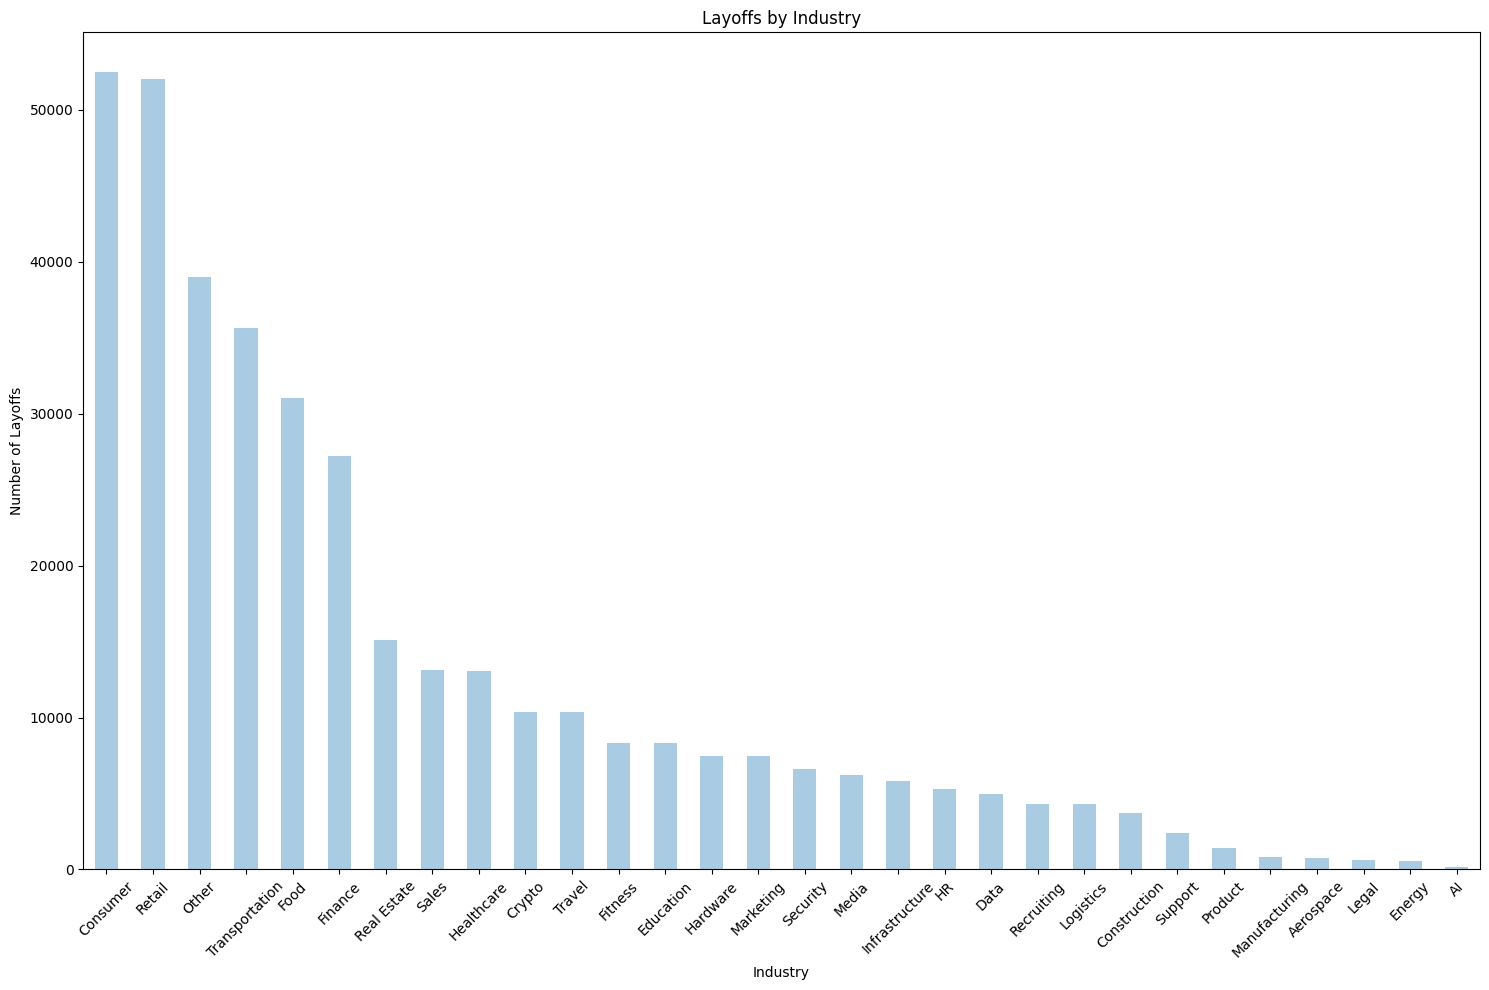

In [6]:
#group data by industry, sum laid-off values
industry_layoffs = df.groupby('Industry')['Laid_Off'].sum().sort_values(ascending=False)

print(industry_layoffs)

#plot for sum of layoffs
plt.figure(figsize = (15, 10))
industry_layoffs.plot(kind = 'bar', color = '#A9CCE3')
plt.title('Layoffs by Industry')
plt.xlabel('Industry')
plt.ylabel('Number of Layoffs')
plt.xticks(rotation=45)
plt.tight_layout()

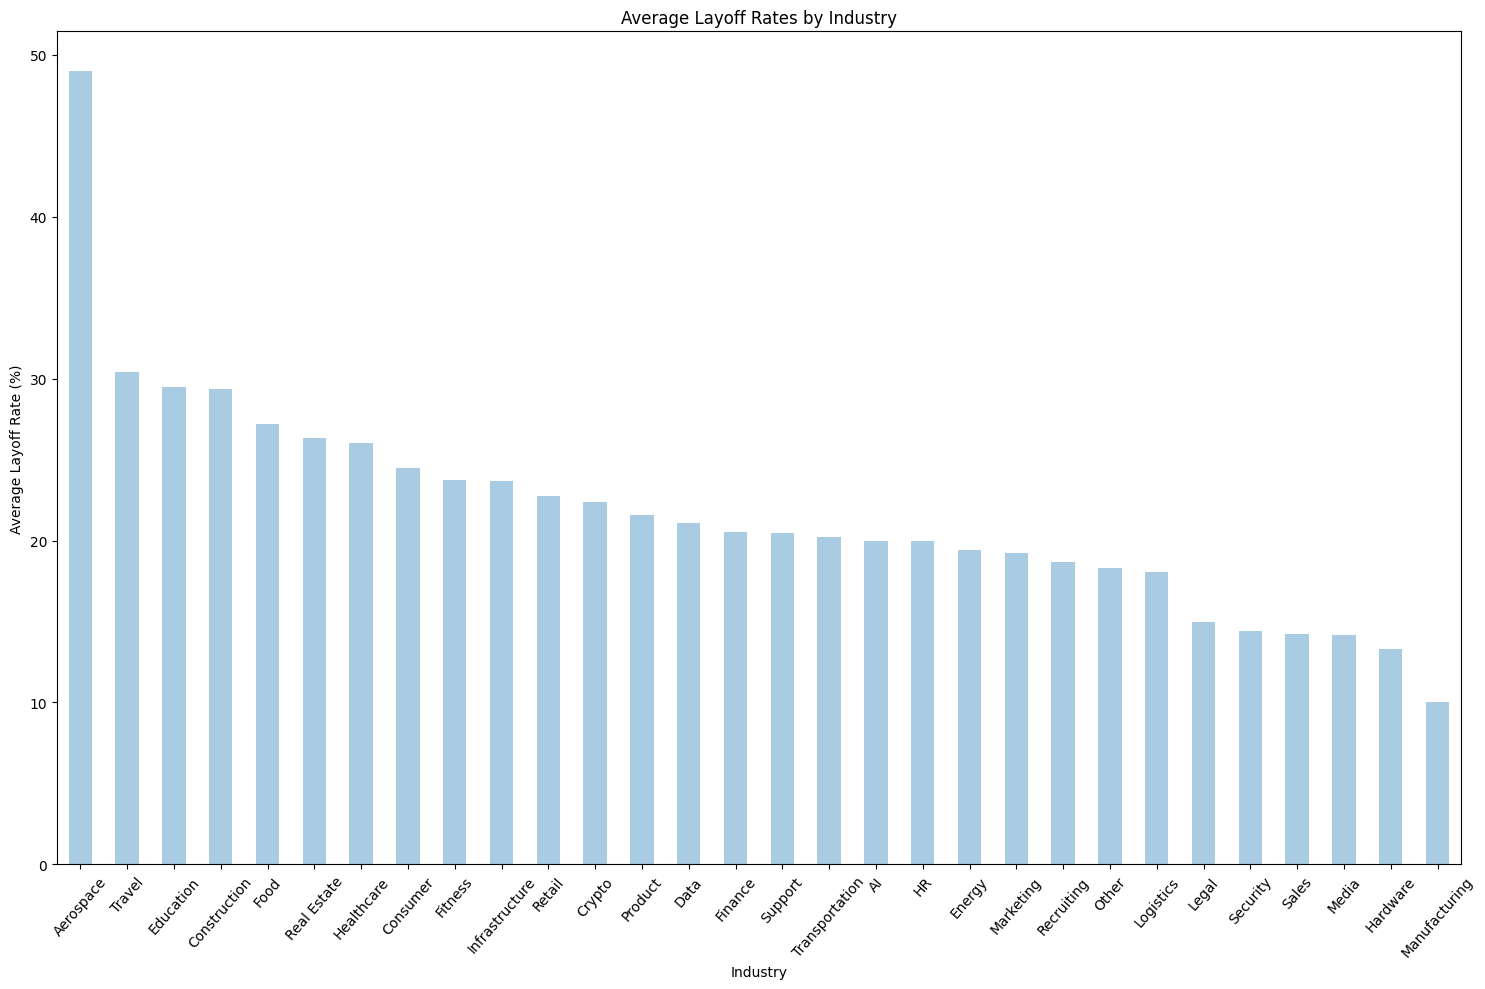

In [7]:
#group by industry percentage
industry_layoff_rates = df.groupby('Industry')['Percentage'].mean().sort_values(ascending=False)

#plot for rates
plt.figure(figsize = (15, 10))
industry_layoff_rates.plot(kind = 'bar', color = '#A9CCE3')
plt.title('Average Layoff Rates by Industry')
plt.xlabel('Industry')
plt.ylabel('Average Layoff Rate (%)')
plt.xticks(rotation=49)
plt.tight_layout()

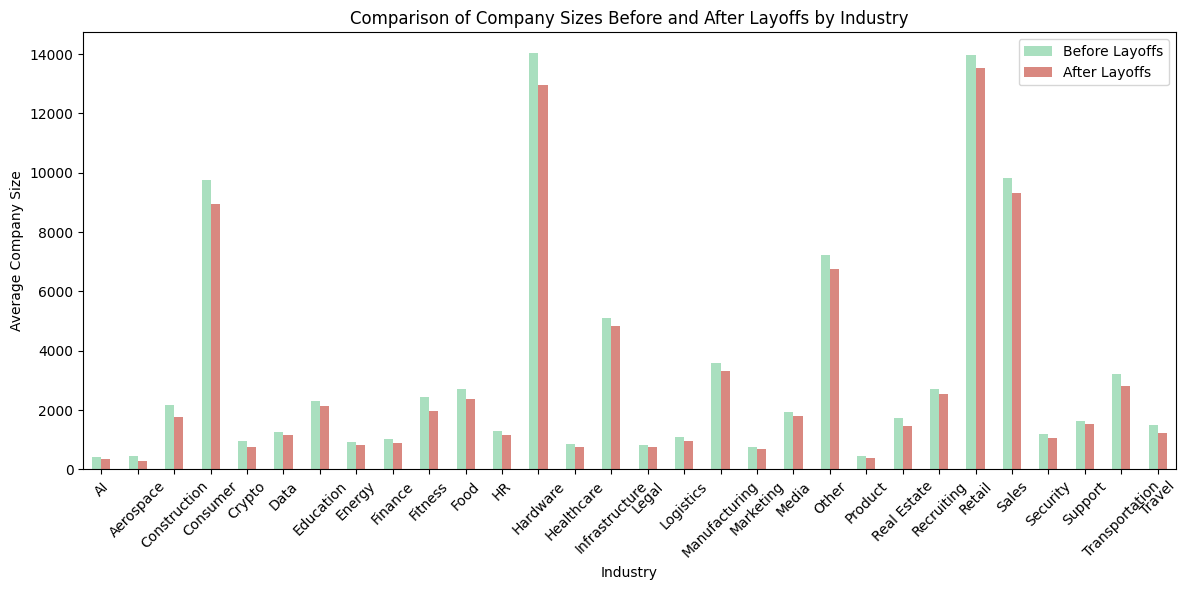

In [8]:
# company size before/after layoffs by industry
industry_sizes = df.groupby('Industry').agg({
    'Company_Size_before_Layoffs': 'mean',
    'Company_Size_after_layoffs': 'mean'
})

#plot
industry_sizes.plot(kind = 'bar', figsize = (12, 6), color  = ['#A9DFBF', '#D98880'])
plt.title('Comparison of Company Sizes Before and After Layoffs by Industry')
plt.xlabel('Industry')
plt.ylabel('Average Company Size')
plt.xticks(rotation = 45)
plt.legend(['Before Layoffs', 'After Layoffs'])
plt.tight_layout()

In [9]:
df['Date_layoffs'] = pd.to_datetime(df['Date_layoffs'])
df.sort_values('Date_layoffs', inplace=True)

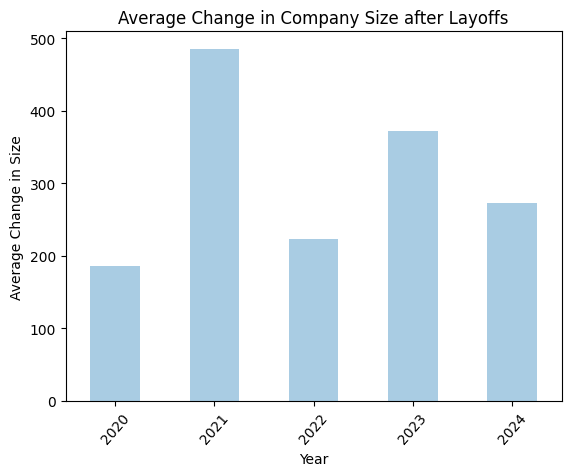

In [10]:
# change in company size
df['Change_in_Size'] = df['Company_Size_before_Layoffs'] - df['Company_Size_after_layoffs']

# plot
df.groupby(df['Date_layoffs'].dt.year)['Change_in_Size'].mean().plot(kind='bar', color = '#A9CCE3')
plt.title('Average Change in Company Size after Layoffs')
plt.xlabel('Year')
plt.ylabel('Average Change in Size')
plt.xticks(rotation=49)

plt.show()

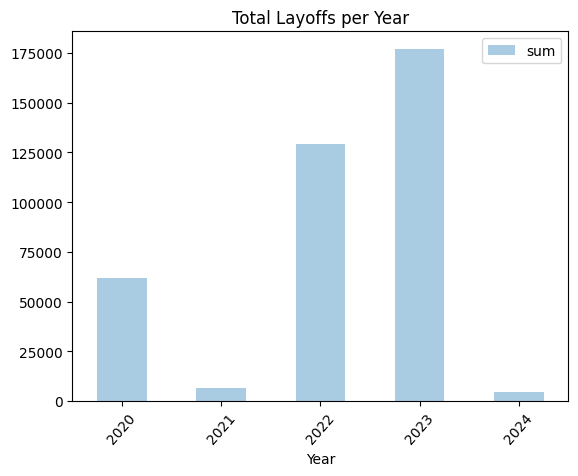

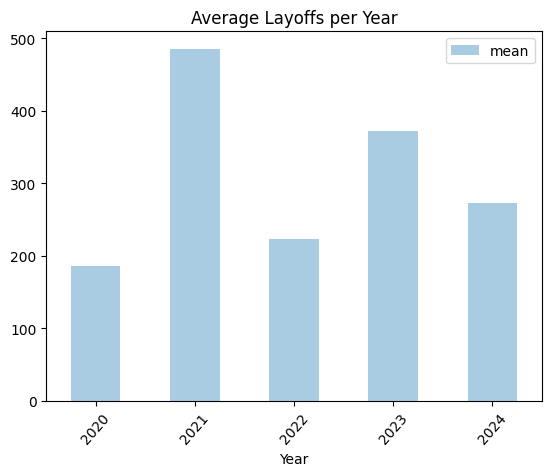

In [11]:
#group by year
df['Year'] = df['Date_layoffs'].dt.year
yearly_layoffs = df.groupby('Year')['Laid_Off'].agg(['sum', 'mean'])

# plot sum layoffs by year
yearly_layoffs.plot(kind='bar', y='sum', title='Total Layoffs per Year', color = '#A9CCE3')
plt.xticks(rotation=49)
plt.show()

#plot mean layoffs per year
yearly_layoffs.plot(kind='bar', y='mean', title='Average Layoffs per Year', color = '#A9CCE3')
plt.xticks(rotation=49)
plt.show()

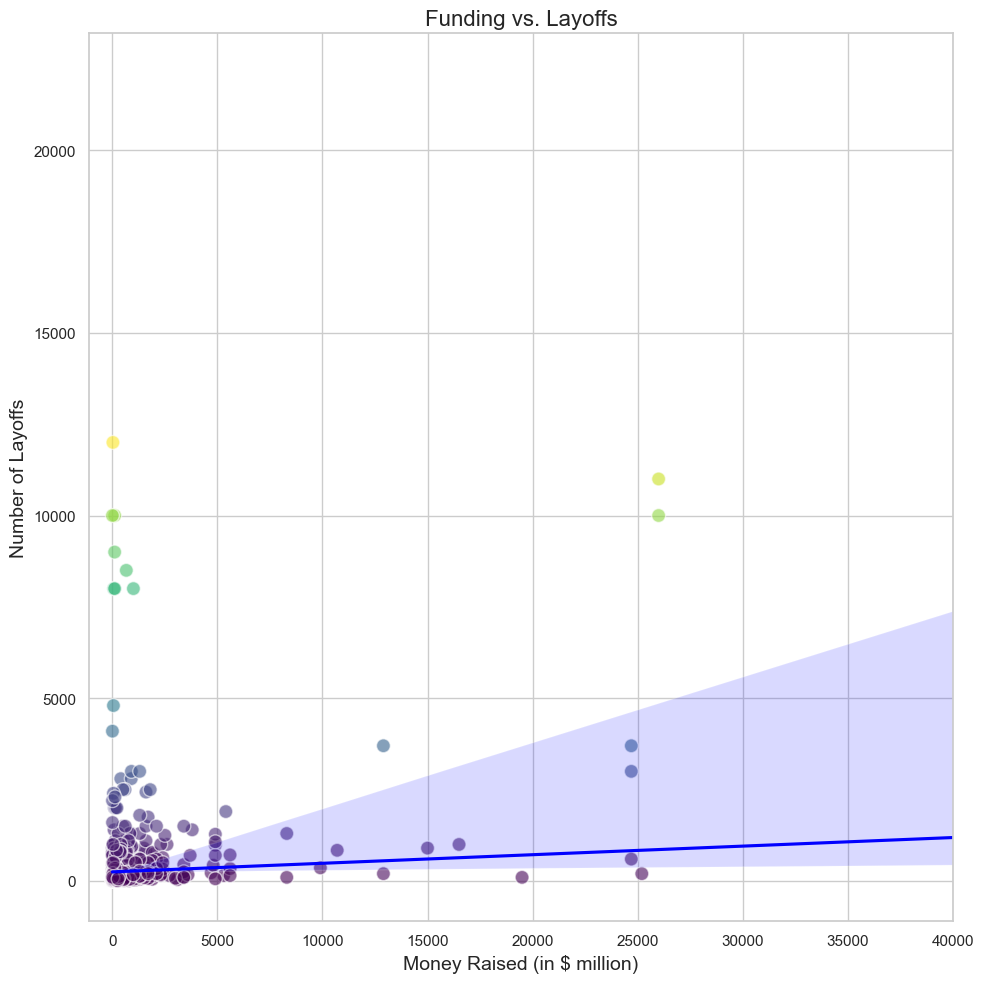

Correlation between funding and layoffs: 0.13323899695887717


In [12]:
sns.set(style="whitegrid")

# plot
plt.figure(figsize=(10, 10))  # Adjust the size of the plot
plt.scatter(df['Funding'], df['Laid_Off'], alpha=0.6, edgecolors='w', s=100, c=df['Laid_Off'], cmap='viridis') 

# line of best fit
sns.regplot(x='Funding', y='Laid_Off', data=df, scatter=False, color='blue')

plt.title('Funding vs. Layoffs', fontsize=16)
plt.xlabel('Money Raised (in $ million)', fontsize=14)
plt.ylabel('Number of Layoffs', fontsize=14)

current_xlim = plt.xlim()
plt.xlim(current_xlim[0], 35000)

current_ylim = plt.ylim()
plt.xlim(current_ylim[0], 40000) 

plt.tight_layout()
plt.show()

# calculate correlation
correlation = df['Funding'].corr(df['Laid_Off'])
print("Correlation between funding and layoffs:", correlation)

## Statistical analysis for layoffs by industry

### t-test

In [13]:
# t-test between lay offs 2020 v 2021

df = df.dropna(subset=['Year', 'Laid_Off'])

# extract
#group1 = df[df['Year'] == 2019]['Laid_Off']
group2 = df[df['Year'] == 2020]['Laid_Off']
group3 = df[df['Year'] == 2021]['Laid_Off']


# check groups not empty
if not group2.empty and not group3.empty:
    t_stat, p_val = stats.ttest_ind(group2, group3, nan_policy='omit')

    print(f"T-statistic: {t_stat}, P-value: {p_val}")
    
else:
    print("One or both groups are empty, cannot perform t-test.")

T-statistic: -2.6871118862417926, P-value: 0.007556343317608741


In [14]:
if p_val < 0.01:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is a significant difference!


In [15]:
# t-test between lay offs 2021 v 2022

df = df.dropna(subset=['Year', 'Laid_Off'])

# extract
#group1 = df[df['Year'] == 2019]['Laid_Off']   // 2019 df = empty, omit
#group2 = df[df['Year'] == 2020]['Laid_Off']
group3 = df[df['Year'] == 2021]['Laid_Off']
group4 = df[df['Year'] == 2022]['Laid_Off']

# check groups not empty
if not group2.empty and not group3.empty:
    t_stat, p_val = stats.ttest_ind(group3, group4, nan_policy='omit')

    print(f"T-statistic: {t_stat}, P-value: {p_val}")
    
else:
    print("One or both groups are empty, cannot perform t-test.")

T-statistic: 1.3521086863168745, P-value: 0.17685772627476665


In [16]:
if p_val < 0.01:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is NOT a significant difference!


In [17]:
# t-test between lay offs 2022 v 2023

df = df.dropna(subset=['Year', 'Laid_Off'])

# extract

group4 = df[df['Year'] == 2022]['Laid_Off']
group5 = df[df['Year'] == 2023]['Laid_Off']

# check groups not empty
if not group2.empty and not group3.empty:
    t_stat, p_val = stats.ttest_ind(group4, group5, nan_policy='omit')

    print(f"T-statistic: {t_stat}, P-value: {p_val}")
    
else:
    print("One or both groups are empty, cannot perform t-test.")

T-statistic: -2.44653785676869, P-value: 0.014586247429764622


In [18]:
if p_val < 0.01:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is NOT a significant difference!


### ANOVA

In [19]:
# ANOVA on layoff rates by industry
df = df.dropna(subset=['Laid_Off'])

model = ols('Laid_Off ~ C(Industry)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                   sum_sq      df         F    PR(>F)
C(Industry)  5.018778e+07    29.0  2.307856  0.000105
Residual     1.040832e+09  1388.0       NaN       NaN


The low p-val suggests that there's statistically significant differences in layoff rates across different industries. 

## Tukey's HSD

In [20]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['Laid_Off'],     # data
                          groups=df['Industry'],    # groups
                          alpha=0.05)               # significance level

print(tukey)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1         group2      meandiff  p-adj    lower      upper   reject
---------------------------------------------------------------------------
            AI      Aerospace       71.6    1.0 -2650.1364 2793.3364  False
            AI   Construction   326.4444    1.0 -2216.6186 2869.5075  False
            AI       Consumer   710.2424    1.0 -1624.6374 3045.1223  False
            AI         Crypto      114.5    1.0  -2229.606  2458.606  False
            AI           Data    18.3333    1.0 -2329.3874  2366.054  False
            AI      Education    77.9412    1.0 -2267.0159 2422.8982  False
            AI         Energy       26.4    1.0 -2695.3364 2748.1364  False
            AI        Finance      51.24    1.0 -2260.5199 2362.9999  False
            AI        Fitness   404.8824    1.0 -2026.9542 2836.7189  False
            AI           Food   259.7111    1.0 -2065.9943 2585.4165  False
            

In [21]:
# convert to df
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

# filter df to show where mean difference is significant
significant_pairs = tukey_df[tukey_df['reject'] == True]

# print the significant pairs
print(significant_pairs)

       group1      group2  meandiff   p-adj      lower     upper  reject
85   Consumer        Data -691.9091  0.0092 -1309.0110  -74.8072    True
86   Consumer   Education -632.3012  0.0286 -1238.8042  -25.7983    True
88   Consumer     Finance -659.0024  0.0000 -1120.7992 -197.2056    True
91   Consumer          HR -659.5501  0.0476 -1316.5835   -2.5168    True
93   Consumer  Healthcare -669.5790  0.0004 -1181.5352 -157.6227    True
98   Consumer   Marketing -706.5639  0.0003 -1241.6591 -171.4686    True
99   Consumer       Media -662.2424  0.0205 -1283.1334  -41.3514    True
106  Consumer    Security -672.4276  0.0085 -1269.3513  -75.5039    True


**Consumer industry has the lowest mean layoff rate.**

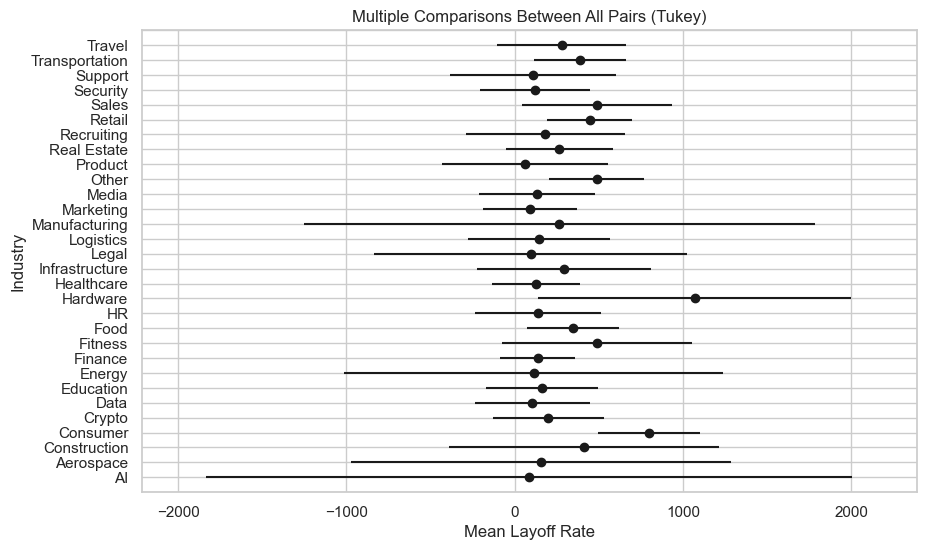

In [22]:
# plot tukey
tukey.plot_simultaneous(xlabel='Mean Layoff Rate', ylabel='Industry')   
plt.show()

**Hardware has higher than average layoff rates.**

# EDA for layoffs by year

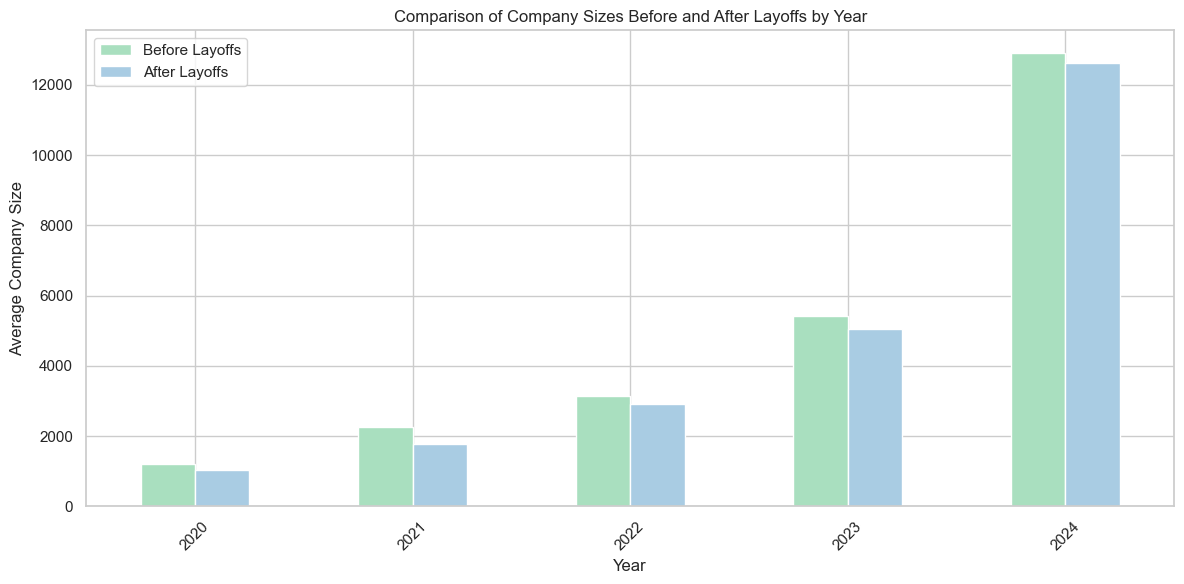

In [23]:
# company size before/after layoffs by industry
industry_sizes = df.groupby('Year').agg({
    'Company_Size_before_Layoffs': 'mean',
    'Company_Size_after_layoffs': 'mean'
})

#plot
industry_sizes.plot(kind = 'bar', figsize = (12, 6), color  = ['#A9DFBF', '#A9CCE3'])
plt.title('Comparison of Company Sizes Before and After Layoffs by Year')
plt.xlabel('Year')
plt.ylabel('Average Company Size')
plt.xticks(rotation = 45)
plt.legend(['Before Layoffs', 'After Layoffs'])
plt.tight_layout()
plt.grid(True)

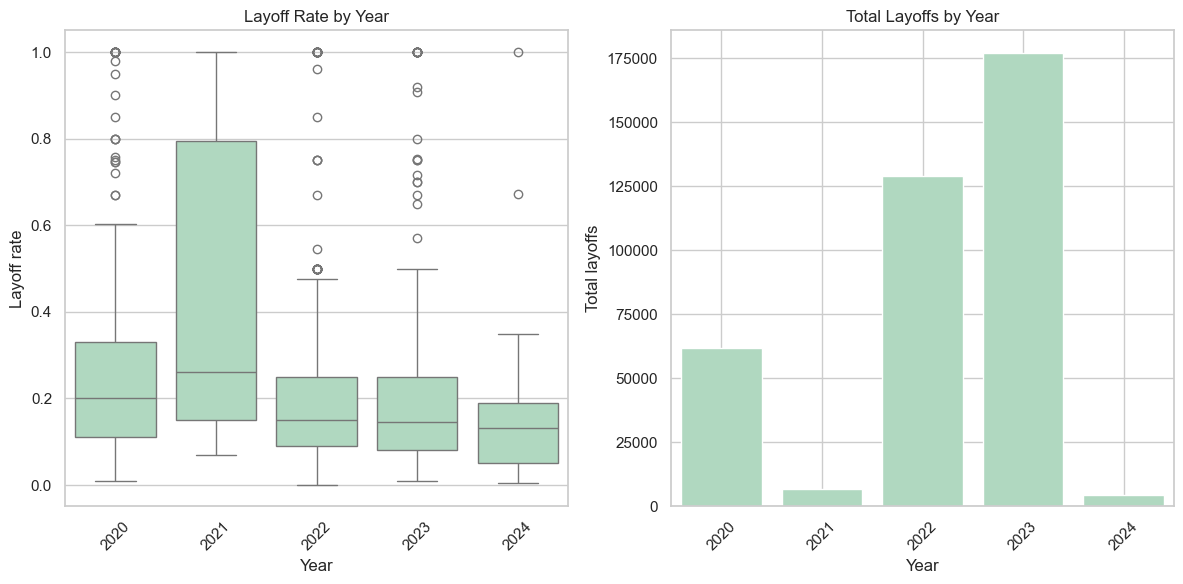

In [24]:
# layoff rate for each company
df['Layoff_Rate'] = df['Laid_Off'] / df['Company_Size_before_Layoffs']

######## plots
plt.figure(figsize=(12, 6))

# layoff rate
plt.subplot(1, 2, 1)
sns.boxplot(x='Year', y='Layoff_Rate', data=df, color = '#A9DFBF')
plt.title('Layoff Rate by Year')
plt.xlabel('Year')
plt.ylabel('Layoff rate')
plt.xticks(rotation = 45)


# total layoffs by year
plt.subplot(1, 2, 2)
total_layoffs_by_year = df.groupby('Year')['Laid_Off'].sum()
sns.barplot(x=total_layoffs_by_year.index, y=total_layoffs_by_year.values, color = '#A9DFBF')
plt.title('Total Layoffs by Year')
plt.xlabel('Year')
plt.ylabel('Total layoffs')
plt.xticks(rotation = 45)
plt.grid(True)


plt.tight_layout()
plt.show()

### time series analysis

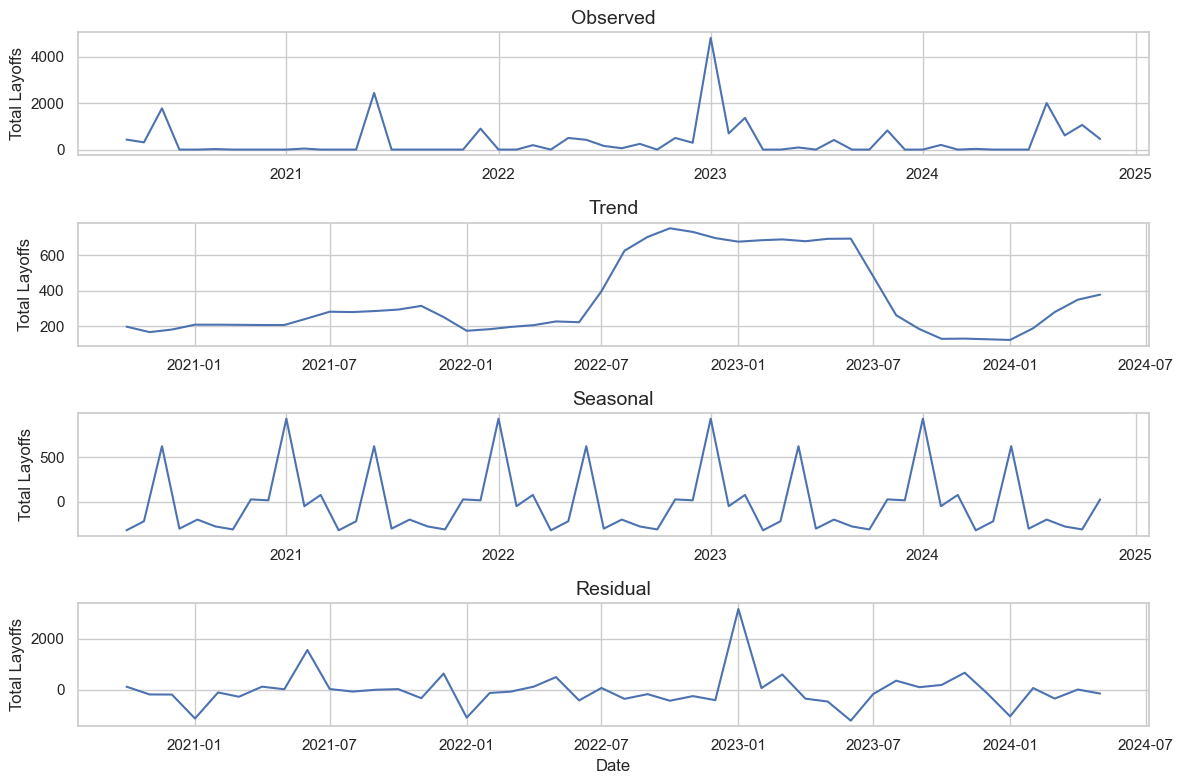

In [27]:
# convert datetime
df['Date_layoffs'] = pd.to_datetime(df['Date_layoffs'])
df.set_index('Date_layoffs', inplace=True)

# aggregate dates if duplicate, sum
df = df.groupby(df.index).sum()

# assign monthly frequency
df = df.asfreq('MS')

# check for missing dates, summing values
df = df.resample('MS').sum()

# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Laid_Off'], model='additive')

### begin plots ###
plt.figure(figsize=(12, 8))

# observed
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.title('Observed', fontsize=14)
plt.ylabel('Total Layoffs', fontsize=12)
plt.grid(True)

# trend
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.title('Trend', fontsize=14)
plt.ylabel('Total Layoffs', fontsize=12)
plt.grid(True)

# seasonal
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal', fontsize=14)
plt.ylabel('Total Layoffs', fontsize=12)
plt.grid(True)

# residual
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.title('Residual', fontsize=14)
plt.ylabel('Total Layoffs', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

__**Observed**__: actual data points (y = sum number of layoffs, x = year or every (approx.) half year)



**__Trend__**: extracted from time series data (long term progression of the series)



**Seasonal**: shows repetitive and predictable movements around trend line (may repesent annual seasonal hiring and firing patterns)



**Residual**: shows leftover variance in the data after accounting for the model (after trend & seasonal data extracted) ; significant spikes represent outliers, where the actual amount of layoffs differed significantly from the model's predicition (aka, COVID and recessions causing mass layoffs)

## Statistical analysis on layoffs by year

### ANOVA

In [28]:
###### begin EDA
descriptive_stats = df.describe()

# layoff rate distribution by year
layoff_rate_by_year = df.groupby('Year')['Layoff_Rate'].describe()

# ANOVA, if layoff rates by year differ
layoff_rates_by_year = [group['Layoff_Rate'].values for _, group in df.groupby('Year')]
anova_results = stats.f_oneway(*layoff_rates_by_year)

# output ANOVA
print("Descriptive Statistics:")
print(descriptive_stats)
print("\nLayoff Rate by Year:")
print(layoff_rate_by_year)
print("\nANOVA Test p-value:")
print(anova_results.pvalue)

Descriptive Statistics:
                #     Laid_Off  Percentage  Company_Size_before_Layoffs  \
count     56.0000    56.000000   56.000000                    56.000000   
mean    3278.8750   371.803571   34.997594                  6234.428571   
std     5923.8093   801.078306   52.658018                 25892.209310   
min        0.0000     0.000000    0.000000                     0.000000   
25%        0.0000     0.000000    0.000000                     0.000000   
50%        0.0000     0.000000    0.000000                     0.000000   
75%     3589.7500   421.500000   56.500000                  2519.500000   
max    34482.0000  4800.000000  213.000000                188450.000000   

       Company_Size_after_layoffs          Year         lat         lng  \
count                   56.000000     56.000000   56.000000   56.000000   
mean                  5862.625000   3033.214286   54.113350 -103.186918   
std                  25612.197805   4626.122730   89.385118  172.387546   


__**Since the calculated p-value is less than 0.001, the results are highly statistically significant, indicating that the variation in layoff rates across different years is not due to random chance (reject the null)**__

### OLS Regression

In [29]:
# regression analysis 
X = df[['Year', 'Company_Size_before_Layoffs']]
X = sm.add_constant(X) 
y = df['Laid_Off']

# regression model
model = sm.OLS(y, X).fit()
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:               Laid_Off   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     6.022
Date:                Tue, 05 Mar 2024   Prob (F-statistic):            0.00440
Time:                        23:18:40   Log-Likelihood:                -447.64
No. Observations:                  56   AIC:                             901.3
Df Residuals:                      53   BIC:                             907.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

__**The F-statistic and its correlating p-value proves that the overall mdel is statistically significant. The p-value for 'Company_Size_before_Layoffs' suggests it is an important factor in prediciting the number of layoffs, while 'Year' does not have a significant effect (according to this model). The large condition number suggests potential multicolinearity issues (predictors might be correlated with each other).**__